In [2]:
import chess
import chess.engine
import math
from chess import Board, Move, Color
from chess.engine import SimpleEngine, Score
from model import Puzzle

In [3]:
engine_path = "/home/fhernandez/Downloads/stockfish-ubuntu-x86-64-sse41-popcnt/stockfish/stockfish-ubuntu-x86-64-sse41-popcnt"
engine = chess.engine.SimpleEngine.popen_uci(engine_path)

In [4]:
engine_limit = chess.engine.Limit(depth = 30, time = 10, nodes = 12_000_000)

Zugzwang is a position where the side to move would rather just pass, but this is not allowed in chess. Any move they make will make their position worse. Here we can force zugzwang!

So the puzzle solver would try to find a move that forces zugzwang on the opponent. 

In [14]:
def zugzwang(engine: SimpleEngine, puzzle: Puzzle) -> bool:
    """ 
    The order of the moves: simulated opponent then puzzle solver.
    For each move the puzzle solver makes, check if the opponent is better off passing (making a null
    move) than making any other move. If making a null move is better, then it is a zugzwang.
    """
    # iterate over solver moves only. I know this because since the null move is pushed by the 
    # opponent, the move played in the previous board must've been the puzzle solver's.
    #
    for node in puzzle.mainline[1::2]:
        board = node.board()

        # These ifs skip the code at the bottom and enters the loop from the start.
        if board.is_check():
            continue     
        if len(list(board.legal_moves)) > 15:
            continue
            
        # score of the opponent
        score = score_of(engine, board, not puzzle.pov)

        rev_board = node.board()
        # imagine the opponent made a null moves
        rev_board.push(Move.null())

        # score of the opponent after making a null move
        rev_score = score_of(engine, rev_board, not puzzle.pov)

        # I don't understand where the 0.3 comes from.
        if win_chances(score) < win_chances(rev_score) - 0.3:
            return True

    return False

In [12]:
# understandin puzzle.mainline[1::2]
l= [0,1,2,3,4,5]
l[1::2]

[1, 3, 5]

In [5]:
def score_of(engine: SimpleEngine, board: Board, pov: Color):
    """ returns the score from the point of view of the parameter pov """
    info = engine.analyse(board, limit = engine_limit)
    if "nps" in info:
        print(f'knps: {int(info["nps"] / 1000)} kn: {int(info["nodes"] / 1000)} depth: {info["depth"]} time: {info["time"]}')
    return info["score"].pov(pov)
    '''
    nps: nodes per second. knps: nodes per second in thousands.
    nodes: number of nodes.
    depth: depth of search.
    '''

In [6]:
def win_chances(score: Score) -> float:
    """
    winning chances from -1 to 1 
    https://graphsketch.com/?eqn1_color=1&eqn1_eqn=100+*+%282+%2F+%281+%2B+exp%28-0.004+*+x%29%29+-+1%29&eqn2_color=2&eqn2_eqn=&eqn3_color=3&eqn3_eqn=&eqn4_color=4&eqn4_eqn=&eqn5_color=5&eqn5_eqn=&eqn6_color=6&eqn6_eqn=&x_min=-1000&x_max=1000&y_min=-100&y_max=100&x_tick=100&y_tick=10&x_label_freq=2&y_label_freq=2&do_grid=0&do_grid=1&bold_labeled_lines=0&bold_labeled_lines=1&line_width=4&image_w=850&image_h=525
    """
    mate = score.mate()
    if mate is not None:
        return 1 if mate > 0 else -1

    cp = score.score()
    return 2 / (1 + math.exp(-0.004 * cp)) - 1 if cp is not None else 0

#### Example

The first solver move is the zugzwang move. No need to check the rest of the puzzle. https://lichess.org/training/E5xBB. 

To understand zugzwang, compare those two positions:
https://lichess.org/analysis/fromPosition/8/8/p2k1p2/1p1p1P2/1P3Kp1/P1P3P1/8/8_b_-_-_4_46 </br>
and </br>
https://lichess.org/analysis/fromPosition/8/8/p2k1p2/1p1p1P2/1P3Kp1/P1P3P1/8/8_w_-_-_5_47

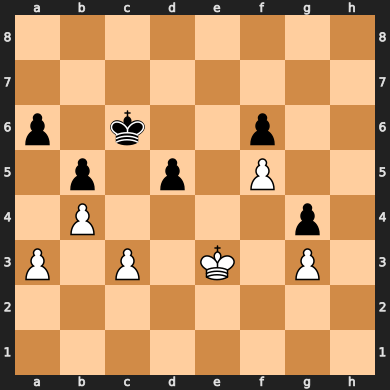

In [34]:
board = Board('8/8/p1k2p2/1p1p1P2/1P4p1/P1P1K1P1/8/8 b - - 2 45')
first_opponet_move = "c6d6"
solver_move = "e3f4"
board

In [35]:
board.push(chess.Move.from_uci(first_opponet_move))
board.push(chess.Move.from_uci(solver_move))

In [32]:
board.fen # now it is black to move

<bound method Board.fen of Board('8/8/p2k1p2/1p1p1P2/1P3Kp1/P1P3P1/8/8 b - - 4 46')>

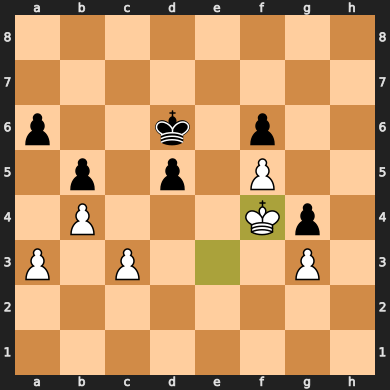

In [16]:
board

Any black move loses misearbly

In [36]:
score = score_of(engine, board, chess.BLACK)
rev_board = board
rev_board.push(Move.null())
rev_score = score_of(engine, rev_board, chess.BLACK)
w1 = win_chances(score)
w2 = win_chances(rev_score)
w3 = win_chances(rev_score) - 0.3

Not transmitting history with null moves to UCI engine


knps: 1456 kn: 12000 depth: 28 time: 8.24
knps: 910 kn: 279 depth: 30 time: 0.307


In [37]:
print(f"score = {score}. rev score= {rev_score}")

score = -710. rev score= 0


Actually black is winning here. rev score equals 0 is the worst option for black.

In [42]:
print(f"w1={w1} \n w2={w2} \n w3={w3} ")

w1=-0.9010926005994883 
 w2=0.0 
 w3=-0.3 


##### Checking that null move actually works

after the null move, the fen is <bound method Board.fen of Board('8/8/p2k1p2/1p1p1P2/1P3Kp1/P1P3P1/8/8 w - - 5 47')>


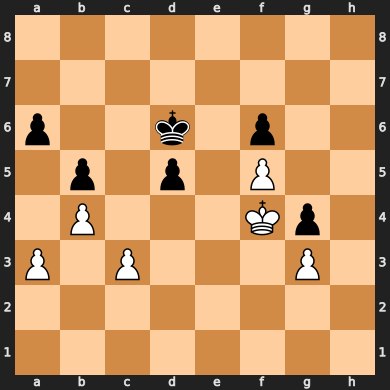

In [33]:
rev_board = board
rev_board.push(Move.null())
print(f"after the null move, the fen is {rev_board.fen}")
# now it is white's turn
rev_board